### Titanic - Machine Learning from Disaster

This is a well known [Kaggle ML](https://www.kaggle.com/c/titanic) competition for beginners to dive into. The goal is to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. 

The competition dataset can be downloaded from this [page](https://www.kaggle.com/c/titanic/data), and is already split into a training set and a test set. Now, let's load and explore our dataset. 

In [1]:
import pandas as pd
import numpy as np

train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The features have the following meaning:
* **Survived**: The target variable, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: Passenger class.
* **Name**, **Sex**, **Age**: Self-explanatory
* **SibSp**: How many siblings and spouses of the passenger aboard the Titanic.
* **Parch**: How many children and parents of the passenger aboard the Titanic.
* **Ticket**: Ticket ID.
* **Fare**:Price paid (in pounds).
* **Cabin**: Passenger's cabin number.
* **Embarked**: Where the passenger embarked the Titanic.

Let's get more info to see how much data we are missing:

In [3]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We see that the the **Age**, **Cabin**, **Embarked**, and **Fare**  features are missing values. Let's see how much data is missing exactly from each of these categories:

In [5]:
train_set.isna().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [6]:
test_set.isna().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

The **Cabin** feature is missing the most data, and its not obvious how to reengineer the missing values. So, we will get rid of it.

In [7]:
train_set.drop('Cabin', axis = 1, inplace = True)
test_set.drop('Cabin', axis = 1, inplace = True)

In [8]:
train_set['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Most passengers have embarked at *S=Southampton*. So we will replace the missing values with *S*.

In [9]:
train_set["Embarked"] = train_set["Embarked"].fillna("S")

We don't need to do anything for the test set since **Embarked** category in test set is not missing any data.

The **Age** feature has about 19% null values. We can replace these null values with the mean or median age. First, let's calculate mean, median, and standard deviations across different subcategories so that we can be more precise when replacing the null values in **Age** category.

In [10]:
Pclass_count_train_set = pd.DataFrame({'Count': train_set.groupby(['Pclass', 'Sex']).size()})

Age_stats_train = pd.pivot_table(train_set, index = ['Pclass', 'Sex'], 
                              values = 'Age', aggfunc = (np.mean, np.std, np.median))

Pclass_count_train_set.join(Age_stats_train, how = 'outer')

Count       mean  median        std
Pclass Sex                                        
1      female     94  34.611765    35.0  13.612052
       male      122  41.281386    40.0  15.139570
2      female     76  28.722973    28.0  12.872702
       male      108  30.740707    30.0  14.793894
3      female    144  21.750000    21.5  12.729964
       male      347  26.507589    25.0  12.159514

The table shows that the mean and median values don't differ by much, and also the standard deviations across all subcategories are not too high. So we can either use mean or the median to replace the null value but we will stick with median. 

In [11]:
Null_values_train_set = {35: (train_set['Pclass'] == 1) & (train_set['Sex'] == 'female') & train_set['Age'].isnull(),
                   40: (train_set['Pclass'] == 1) & (train_set['Sex'] == 'male') & train_set['Age'].isnull(),
                   28: (train_set['Pclass'] == 2) & (train_set['Sex'] == 'female') & train_set['Age'].isnull(),
                   30: (train_set['Pclass'] == 2) & (train_set['Sex'] == 'male') & train_set['Age'].isnull(),
                   21.5: (train_set['Pclass'] == 3) & (train_set['Sex'] == 'female') & train_set['Age'].isnull(),
                   25: (train_set['Pclass'] == 3) & (train_set['Sex'] == 'male') & train_set['Age'].isnull()}

In [12]:
for replacement_value, condition in Null_values_train_set.items(): 
    train_set.loc[condition, 'Age'] = replacement_value

In [13]:
train_set.isna().sum().sort_values(ascending=False)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Let's do the same for the test set.

In [14]:
Pclass_count_test_set = pd.DataFrame({'Count': test_set.groupby(['Pclass', 'Sex']).size()})

Age_stats_test = pd.pivot_table(test_set, index = ['Pclass', 'Sex'], 
                              values = 'Age', aggfunc = (np.mean, np.std, np.median))

Pclass_count_test_set.join(Age_stats_test, how = 'outer')

Count       mean  median        std
Pclass Sex                                        
1      female     50  41.333333    41.0  14.541698
       male       57  40.520000    42.0  13.507352
2      female     30  24.376552    24.0  12.697827
       male       63  30.940678    28.0  12.610233
3      female     72  23.073400    22.0  11.128369
       male      146  24.525104    24.0  10.240251

In [15]:
Null_values_test_set = {41: (test_set['Pclass'] == 1) & (test_set['Sex'] == 'female') & test_set['Age'].isnull(),
                   42: (test_set['Pclass'] == 1) & (test_set['Sex'] == 'male') & test_set['Age'].isnull(),
                   24.01: (test_set['Pclass'] == 2) & (test_set['Sex'] == 'female') & test_set['Age'].isnull(),
                   28: (test_set['Pclass'] == 2) & (test_set['Sex'] == 'male') & test_set['Age'].isnull(),
                   22: (test_set['Pclass'] == 3) & (test_set['Sex'] == 'female') & test_set['Age'].isnull(),
                   24: (test_set['Pclass'] == 3) & (test_set['Sex'] == 'male') & test_set['Age'].isnull()}

The reader may notice that for the third condition in the above dictionary I have used 24.01 as the replacement value. The reason for this is that Python doesn't allow two keys to have the same value. There are different ways one can bypass this, but, for the sake of simplicity, I just did a quick fix by making one of the median values 24.01.  

In [16]:
for replacement_value, condition in Null_values_test_set.items(): 
    test_set.loc[condition, 'Age'] = replacement_value

In [17]:
test_set.isna().sum().sort_values(ascending=False)

Fare           1
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Embarked       0
dtype: int64

The **Fare** in test set is missing one value which we will replace with the mean as well.

In [18]:
test_set["Fare"] = test_set["Fare"].fillna(test_set["Fare"].median())

In [19]:
test_set.isna().sum().sort_values(ascending=False)

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

The **Name**, **Ticket** and **Sex** attributes are categorical variables and their values need to be transformed into numerical values before feeding them into any ML models. The **Name** and **Ticket** attributes may have some value, but again there is no obvious way of transforming their values to useful numerical values that an ML model can consume. So for our initial ML model we will ignore these two attributes.

It remains to decide what to do with **SibSp** and **Parch**. Let's use a count plot to visualize both categories.

In [20]:
import seaborn as sns

sns.set_style("darkgrid")

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn')

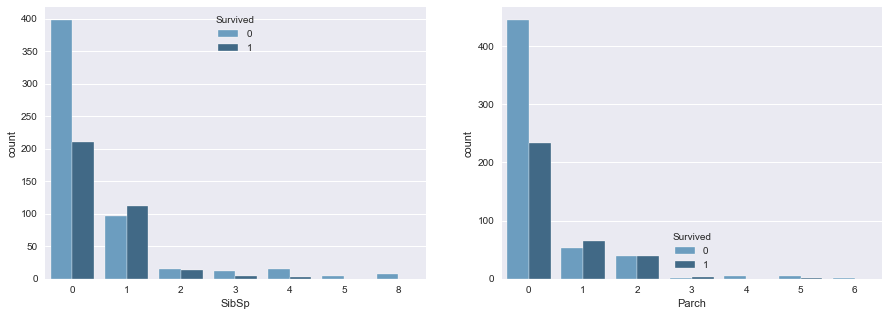

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))

sns.countplot(data = train_set, x = 'SibSp', ax=ax[0], 
            hue = 'Survived', palette = ("Blues_d"))

sns.countplot(data = train_set, x = 'Parch', ax=ax[1], 
            hue = 'Survived', palette = ("Blues_d"));


It looks like both features have several subcategories that contain only a few values. It is better to combine them by creating a new feature called **Family_size** that takes into account the relationship between these two features. We do this as follows.   

In [22]:
train_set['Family_size_tmp'] = train_set['SibSp'].astype('int') + train_set['Parch'].astype('int') + 1

test_set['Family_size_tmp'] = test_set['SibSp'].astype('int') + test_set['Parch'].astype('int') + 1

In [23]:
conditions_train = [(train_set['Family_size_tmp'] == 1),
                (train_set['Family_size_tmp'] == 2),
                (train_set['Family_size_tmp'] > 2) & (train_set['Family_size_tmp'] < 5),
                (train_set['Family_size_tmp'] > 4)]

values_train = ['Alone', 'Small', 'Medium', 'Large']

In [24]:
train_set['Family_size'] = np.select(conditions_train, values_train)

In [25]:
conditions_test = [(test_set['Family_size_tmp'] == 1),
                (test_set['Family_size_tmp'] == 2),
                (test_set['Family_size_tmp'] > 2) & (test_set['Family_size_tmp'] < 5),
                (test_set['Family_size_tmp'] > 4)]

values_test = ['Alone', 'Small', 'Medium', 'Large']

In [26]:
test_set['Family_size'] = np.select(conditions_test, values_test)

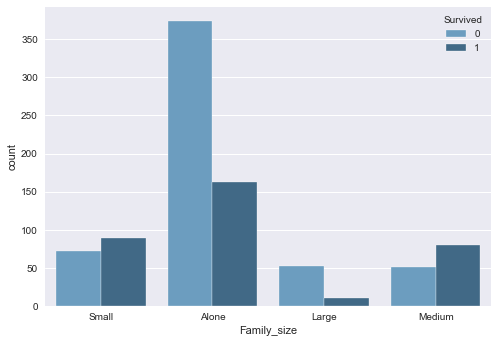

In [27]:
sns.countplot(x = train_set['Family_size'], hue = train_set['Survived'], 
              palette = ("Blues_d"));

Let's not forget to drop the features that are not used .

In [28]:
train_set.drop(['SibSp', 'Parch', 'Family_size_tmp'], axis = 1, inplace = True)
test_set.drop(['SibSp', 'Parch', 'Family_size_tmp'], axis = 1, inplace = True)

In [29]:
train_set.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,Alone


Finally, we need to decide what to do with **Fare**. Let's look at the following graph and see what we get.

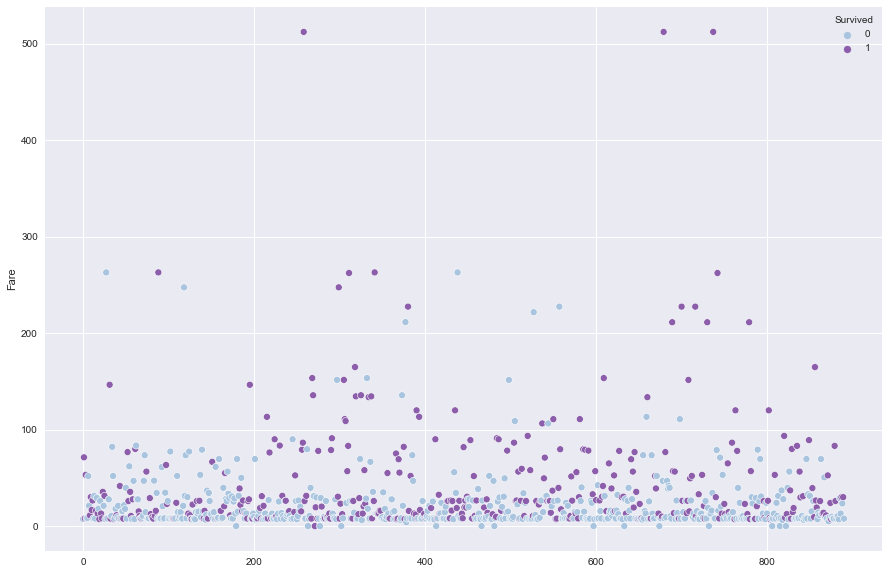

In [36]:

ax = plt.subplots(1, 1, figsize = (15, 10))
sns.scatterplot(x=train_set["Fare"].index, y=train_set['Fare'],
                hue =train_set['Survived'], palette = ("BuPu"));

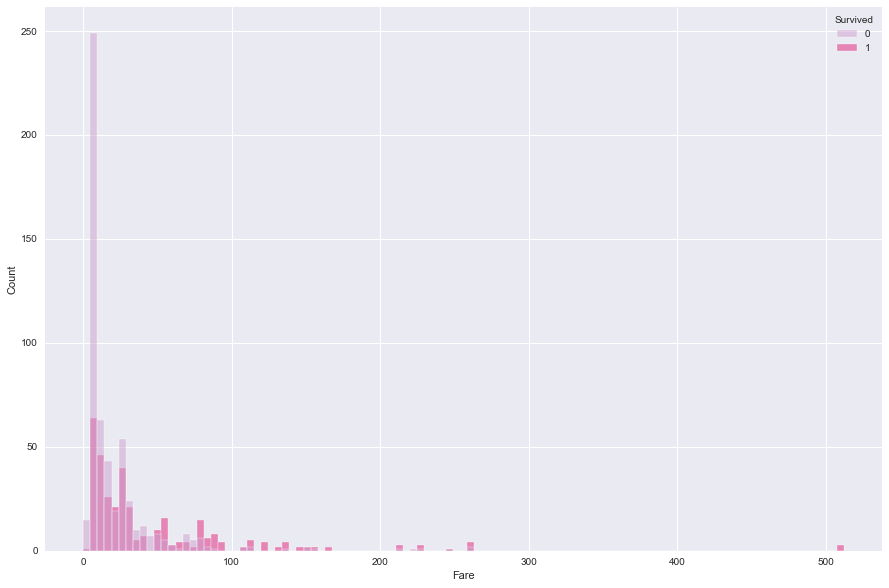

In [81]:
ax = plt.subplots(1, 1, figsize = (15, 10))
sns.histplot(x = train_set['Fare'], hue = train_set['Survived'],
              palette = ("PuRd"));

We can see from graphs (especially the second one) that **Fare** is significantly skewed towards left (lower fares). We could use binning to remedy this, but unfortunately there is no fixed bin width that we can use to make the **Fare** have a more  uniform distribution which is due to the fact that the prices seems very arbitrary. So, we will leave **Fare** as it is but will scale its values.     

Let's build our preprocessing pipeline now:

In [82]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [83]:
cat_encoder = OneHotEncoder()
std_scaler = StandardScaler()

num_attribs = ["Fare",'Age']
cat_attribs = ['Sex', 'Embarked', 'Family_size']# We are not including Pclass since it is already encode it.

preprocess_pipeline = ColumnTransformer([
        ("num", std_scaler, num_attribs),
        ("cat", cat_encoder, cat_attribs) 
    ])


Now, we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [84]:
X_train_prepared = preprocess_pipeline.fit_transform(train_set)
X_train_prepared

array([[-0.50244517, -0.53489116,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.78684529,  0.66839176,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.48885426, -0.23407043,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.17626324, -0.57249375,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.04438104, -0.23407043,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.49237783,  0.21716066,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

We also need the labels!!

In [85]:
y_train = train_set['Survived']

We are all ready to train our ML models now. Let's us try a few different ones and use cross-validation to see which one is the best.

In [86]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

In [87]:
from sklearn.model_selection import cross_val_score

In [88]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train_prepared, y_train, cv=10)
svm_scores.mean()


0.8271785268414481

In [89]:
forest_clf = RandomForestClassifier()
forest_scores = cross_val_score(forest_clf, X_train_prepared, y_train, cv=10)
forest_scores.mean()

0.7946816479400749

In [90]:
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train_prepared, y_train, cv=10)
knn_scores.mean()

0.7913358302122347

In [91]:
sgd_clf = SGDClassifier(random_state=42)
sgd_scores = cross_val_score(sgd_clf, X_train_prepared, y_train, cv=10)
sgd_scores.mean()

0.7946691635455679

`SVC` seems to give the best results. But let's see how well our classifier is at predicting the correct labels by looking at the confusion matrix, precision and recall score for our classifier.

In [97]:
from sklearn.model_selection import cross_val_predict

In [98]:
y_train_predictions =cross_val_predict(svm_clf, X_train_prepared, y_train, cv=3)

In [99]:
from sklearn.metrics import confusion_matrix

In [100]:
confusion_matrix(y_train,y_train_predictions)

array([[487,  62],
       [ 97, 245]], dtype=int64)

We note that each row in confucion matrix represents an *actual class*, while each column represents a *predicted class*. So, the first row of the above matrix represents the passengers who didn't survive (the negative class): 487 of them were correctly classified as not survived (true negatives), while the remaining 62 were incorrectly classified as survived (false negatives) by the classifier. The second row represents the survivors (the positive class): 97 of them were incorrectly classified as not survived (false negatives), while the remaining 245 were correctly classified as survived (true positives). This shows that the accuracy score of %82 is a bit missleading. Let's look at the other scores to get a better sense of how good our classifier is at predicting correct labels.


In [103]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

In [104]:
precision_score(y_train,y_train_predictions), recall_score(y_train,y_train_predictions)

(0.7980456026058632, 0.716374269005848)

These scores tell us that:
- When the classifier claims that a passenger survived, it is correct only 79.8% of the time.
- Moreover, it only detects 71.6% of the passengers who survived. 

We can try to improve these scores by using `GridSearchCV` to look for the optimal hyperparamaters for our model. But, I don't think we will see a significant improvement of these scores. Below we plot two graphs that show the Precison/Recall Trade-off for our model. 

In [108]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

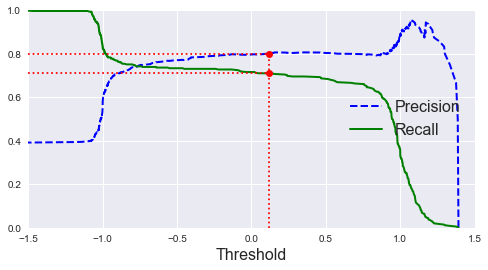

In [109]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-1.5, 1.5, 0, 1])             


recall_80_precision = recalls[np.argmax(precisions >= 0.80)]
threshold_80_precision = thresholds[np.argmax(precisions >= 0.80)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_80_precision, threshold_80_precision], [0, 0.8], "r:")                 
plt.plot([-1.5, threshold_80_precision], [0.8, 0.8], "r:")                                
plt.plot([-1.5, threshold_80_precision], [recall_80_precision, recall_80_precision], "r:")
plt.plot([threshold_80_precision], [0.8], "ro")                                             
plt.plot([threshold_80_precision], [recall_80_precision], "ro")                             
                                        
plt.show()

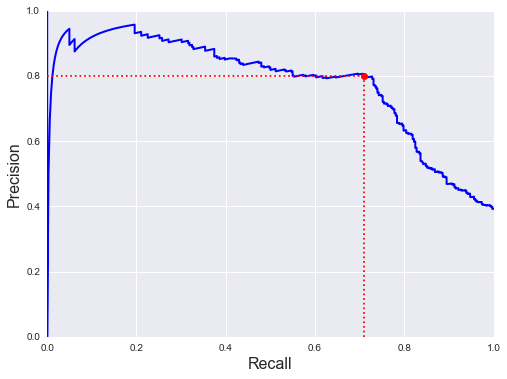

In [110]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_80_precision, recall_80_precision], [0., 0.8], "r:")
plt.plot([0.0, recall_80_precision], [0.8, 0.8], "r:")
plt.plot([recall_80_precision], [0.8], "ro")
plt.show()

We are now ready to train our model.


In [113]:
svm_clf.fit(X_train_prepared,y_train)

SVC(gamma='auto')

Finally, let's use the trained model to make predicitons on the test set.

In [115]:
X_test_prepared = preprocess_pipeline.fit_transform(test_set)
y_predictions = svm_clf.predict(X_test_prepared)

In [116]:
y_predictions_df = pd.concat([test_set["PassengerId"],pd.DataFrame(y_predictions,columns = ["Survived"])],axis=1)

In [117]:
y_predictions_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [118]:
y_predictions_df['Survived'].value_counts()

0    262
1    156
Name: Survived, dtype: int64

In [119]:
y_predictions_df.to_csv("my_submission1.csv", index=False)

Our submission scored 0.77990. Currently, the ranking for that score is 3559.
